<a href="https://colab.research.google.com/github/felipevarelacarvalho/SeedDetection/blob/main/Seed_Detection_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and mounting drive

In [ ]:
import pandas as pd
import numpy as np
import cv2
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torch.utils.data import DataLoader, Dataset

In [ ]:
#library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
import argparse
import shutil

from lxml import etree
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

import torchvision
import seaborn as sns
from PIL import Image, ImageDraw

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_directory = "/content/drive/MyDrive/Colab Notebooks/DataSet/task_miniset_felipe-2021_08_31_19_40_53-cvat for images 1.1/images/Images_Bulk_labelling_mini/MiniSET5"
annotations_directory = "/content/drive/MyDrive/Colab Notebooks/DataSet/task_miniset_felipe-2021_08_31_19_40_53-cvat for images 1.1/annotations.xml"

# Pre-Processing

## Create data frame of annotations

Since we are using custom data and a custom image labeler, we wrote our own parser. We are only worried about the "seed bounding boxes" for this project

Goal: Parse XML file with labels into a dataframe

In [ ]:
#XML parser 
#One XML contains all the images annotation. 
#This parser creates a list of dictionaries containing the image name with the coordinates of the bounding box of the seed. 
root = etree.parse(annotations_directory).getroot()
anno = []
image_info = {}

for image in root.iter('image'):
  #print(image.attrib)
  image_name = image.attrib['name']
  image_width = image.attrib['width']
  image_height = image.attrib['height']
  #print(image_name)
  #image_info = {'name':image_name}

  for box in image.findall('box'):
    if box.attrib['label'] == 'Seed':
      #print(box.items())
      
      for key, value in box.items():
        image_info['name'] = image_name
        image_info['width'] = image_width
        image_info['height'] = image_height
        image_info[key] = value
        #print(image_info.keybs())
      #print(image_info)
      
      #print(anno)
      anno.append(image_info)
      image_info = {} 

In [ ]:
#Creates a dataframe out of the list of dictionaries
width = []
height = []
image_name = []
labels =[]
xtl = []
ytl = []
xbr = []
ybr = []

for item in anno:
  #print(item.keys())
  image_name.append(item['name'])
  width.append(item['width'])
  height.append(item['height'])
  labels.append(0)
  xtl.append(float(item['xtl']))
  ytl.append(float(item['ytl']))
  xbr.append(float(item['xbr']))
  ybr.append(float(item['ybr']))

df = pd.DataFrame(list(zip(image_name, width, height, labels, xtl, ytl,xbr,ybr)),
               columns =['Name','width', 'height', 'Label', 'xmin', 'ymin','xmax','ymax'])


In [ ]:
df.head(3)

Name width  ...    xmax    ymax
0  image_sensorid_4_frame_312300_ts_1620159456.28...  1086  ...  522.79  810.54
1  image_sensorid_4_frame_312292_ts_1620159455.75...  1086  ...  513.96  201.17
2  image_sensorid_4_frame_312292_ts_1620159455.75...  1086  ...  479.06  812.22

[3 rows x 8 columns]

In [ ]:
df_train = df

## Sample Image with Bounding Box

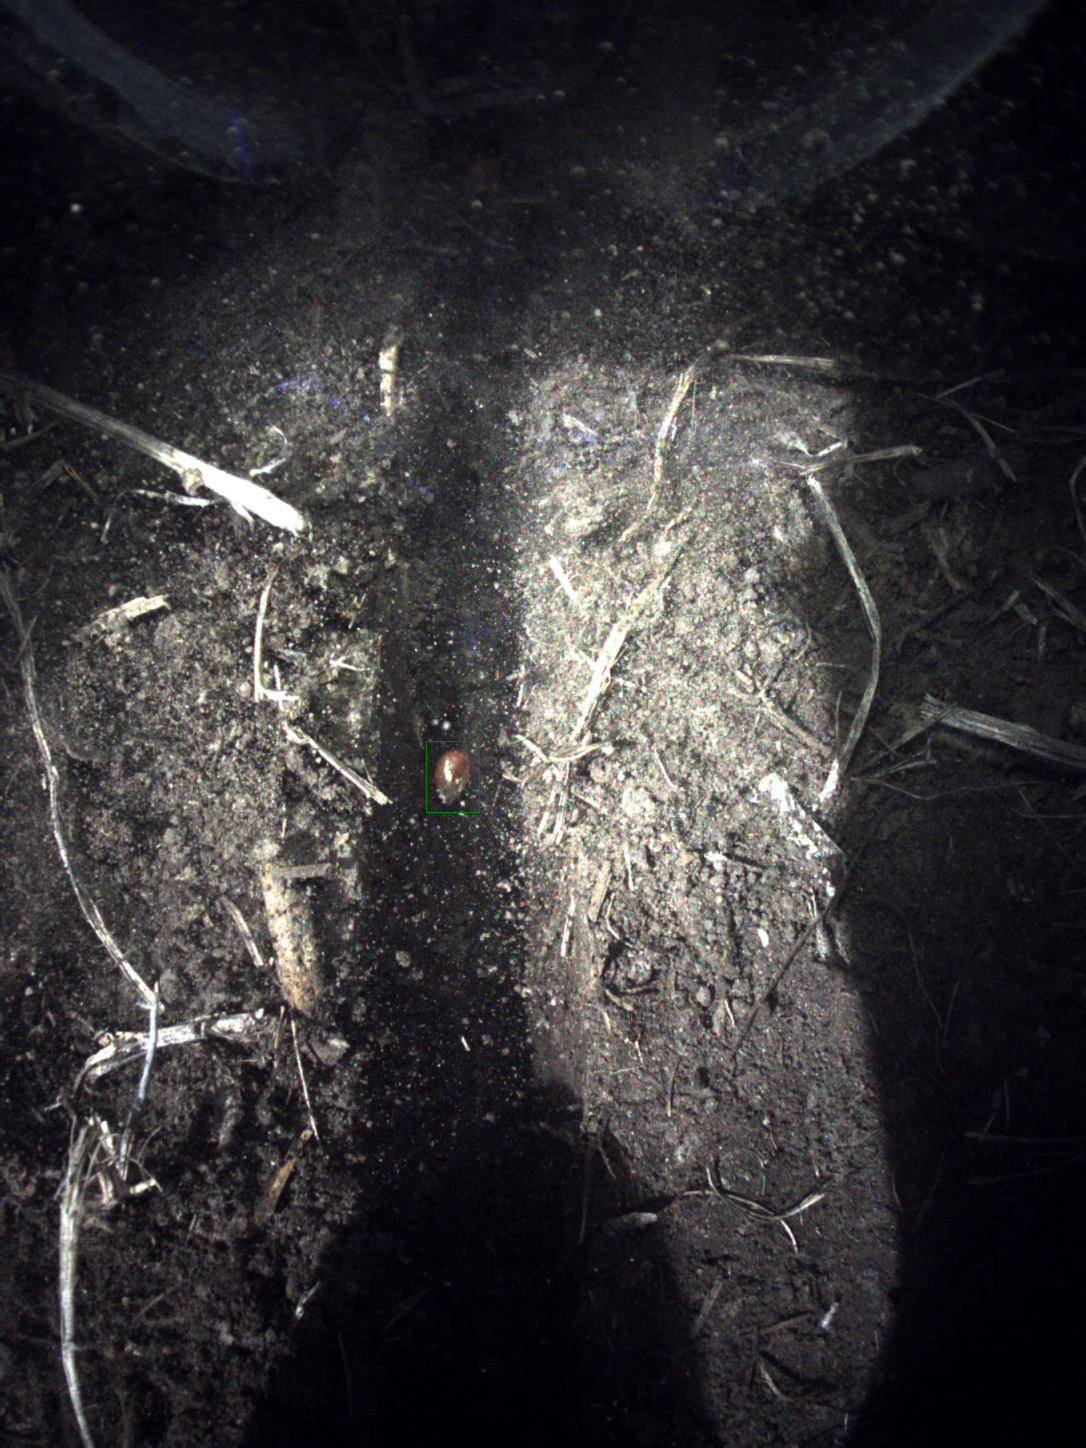

In [ ]:
# Show sample image
sample_image = Image.open(image_directory + '/' + anno[2]['name'])
box_coor = [float(anno[2]['xtl']), float(anno[2]['ytl']), float(anno[2]['xbr']), float(anno[2]['ybr'])]
img_bbox = ImageDraw.Draw(sample_image)
img_bbox.rectangle(box_coor, outline="green") 

sample_image

## Image Mask

Goal: Show mask from bounding box. This was created as a sanity check to make sure that our bounding boxes imported correctly.

In [ ]:
# Code source: https://towardsdatascience.com/bounding-box-prediction-from-scratch-using-pytorch-a8525da51ddc
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])

## Sample Image with Mask

In [ ]:
# im = cv2.imread(str(df_train.values[58][8]))
im = cv2.imread( image_directory + '/' + str(df_train.values[58][0]))
bb = create_bb_array(df_train.values[58])
print(bb)
print(im.shape)

[369.92 465.61 418.69 509.33]
(1448, 1086, 3)


In [ ]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([369., 465., 417., 508.], dtype=float32)

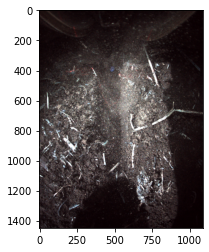

In [ ]:
plt.imshow(im)

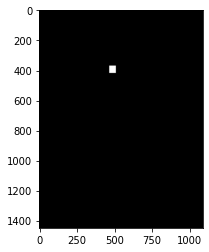

In [ ]:
plt.imshow(Y, cmap='gray')

# Resizng Images and Bounding Boxes

In [ ]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [ ]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, int(0.75*sz)))
    Y_resized = cv2.resize(create_mask(bb, im), (sz, int(0.75*sz)))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    
    return new_path, mask_to_bb(Y_resized)

In [ ]:
#Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
train_path_resized = Path('/content/drive/MyDrive/Colab Notebooks/DataSet/images_resized')
for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(Path(image_directory + '/' + row['Name']), train_path_resized, create_bb_array(row.values), 600)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

# Generating Dataset

Goal: From out custom data set, we need to create a training data set to be able to input it to the py_torch data loader. In this case, we used our dataframe as input.

The py_torch documentation requires us to create the following methods:

__inint__

__getitem__

__len__

This class was inspired by a project in which the author used the model to detect faces

Reference: https://blog.francium.tech/object-detection-with-faster-rcnn-bc2e4295bf49

In [ ]:
class TrainDataset(Dataset):
  def __init__(self, annotation_dataframe):
      self.train_df = annotation_dataframe
      self.image_ids = self.train_df['Name']

  def __getitem__(self, index):
      image_id = self.image_ids[index]
      bboxes = self.train_df[self.train_df['Name'] == image_id]

      image = cv2.imread(f'/content/drive/MyDrive/Colab Notebooks/DataSet/task_miniset_felipe-2021_08_31_19_40_53-cvat for images 1.1/images/Images_Bulk_labelling_mini/MiniSET5/{image_id}', cv2.IMREAD_COLOR)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
      image /= 255.0 # Apply normalization

      boxes = bboxes[['xmin', 'ymin', 'xmax', 'ymax']].values
      area = (boxes[:,3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

      boxes = torch.as_tensor(boxes, dtype=torch.float32)
      area = torch.as_tensor(area, dtype = torch.float32)

      labels = torch.ones((bboxes.shape[0],), dtype = torch.int64)
      iscrowd = torch.zeros((bboxes.shape[0],), dtype = torch.int64)

      target = {}
      target['boxes'] = boxes
      target['labels'] = labels
      target['image_id'] = torch.tensor([index])
      target['area'] = area
      target['iscrowd'] = iscrowd

      image = torchvision.transforms.ToTensor()(image)
      return image, target

  def __len__(self) -> int:
      return self.image_ids.shape[0]

  

It is now possible to use Py_torch's dataloader to load our custom dataset with tensors

In [ ]:
# Initialize Dataset
train_dataset = TrainDataset(df_train)

def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

Use GPU is available

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Plot bounding box from our dataloader. Sanity check to see if data is still aligned

[467 743 522 810]
(1448, 1086, 3)


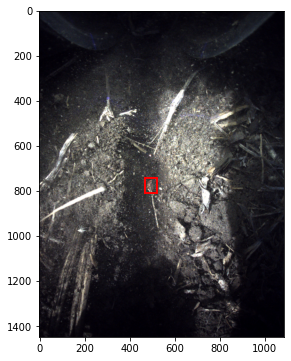

In [ ]:
import matplotlib.patches as patches
images, targets = next(iter((train_data_loader)))
images = list(image.to(device) for image in images)
targets = [{k : v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
img = images[0].permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.imshow(img)

print(box)
rect = patches.Rectangle((box[0], box[1]), box[2] -  box[0], box[3] - box[1], linewidth = 2, edgecolor = 'r', facecolor = 'none')
ax.add_patch(rect)
print(img.shape)


# Initializing model

We are using fasterRCNN deep convolutional network. This is a standard for object detection with fast training speeds and good accuracy. Since we are training images never seen before, we cannot use a pretrained model. Our references mostly used Fast RCNN as well, therefore we deficed to attempt to use that model

The resnet50 backbone allowed us to use an amount of layers that sounded reasonable given the small amount of features we need to extract (only worried about the seed in the image)

In [ ]:
# Declare our model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = False)
# Learn seed and background
num_classes = 2
# Create box predictor - Goal: predict bounding box around seed
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

We will be using Stochastic Gradient Descent for our loss with an added momentum of 0.9 and weight decay of 0.0005. Due to time constraints we followed the values used by our reference.

Reference: https://blog.francium.tech/object-detection-with-faster-rcnn-bc2e4295bf49

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 40

Transfer model to CUDA

In [ ]:
if torch.cuda.is_available():
    model.cuda()

# Train

In [ ]:
model.train()

In [ ]:
itr = 1

for epoch in range(num_epochs):
  for images, targets in train_data_loader:
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k , v in t.items()} for t in targets]
    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict. values())
    loss_value = losses.item()

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    if itr % 50 == 0:
      print(f"Iteration #{epoch} loss:{loss_value}")
    itr += 1

    lr_scheduler.step()

  print(f"Epoch #{epoch} loss: {loss_value}")

torch.save(model.state_dict(), 'model.pth')
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict' : optim.state_dict()
}, 'ckpt.pth')

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iteration #0 loss:0.8359516263008118
Iteration #0 loss:0.7681622505187988
Epoch #0 loss: 63.23744583129883
Iteration #1 loss:0.7669637203216553
Iteration #1 loss:0.7767303586006165
Iteration #1 loss:0.8294751644134521
Epoch #1 loss: 67.26703643798828
Iteration #2 loss:0.7669426798820496
Iteration #2 loss:0.7408164143562317
Iteration #2 loss:0.7526507377624512
Epoch #2 loss: 61.539154052734375
Iteration #3 loss:0.7941802144050598
Iteration #3 loss:0.7671344876289368
Iteration #3 loss:70.68594360351562
Epoch #3 loss: 67.95712280273438
Iteration #4 loss:0.7988240122795105
Iteration #4 loss:0.7955721020698547
Epoch #4 loss: 66.42747497558594
Iteration #5 loss:0.7776979804039001
Iteration #5 loss:0.817018449306488
Iteration #5 loss:0.7844449281692505
Epoch #5 loss: 66.52404022216797
Iteration #6 loss:0.7913725972175598
Iteration #6 loss:0.8037188649177551
Iteration #6 loss:0.8055294156074524
Epoch #6 loss: 65.84149169921875
Iteration #7 loss:0.8061094284057617
Iteration #7 loss:0.7365382909

AttributeError: ignored

In [ ]:
torch.save(model.state_dict(), 'model.pth')
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict()
}, 'ckpt.pth')

# TestDataset

In [ ]:
from google.colab.patches import cv2_imshow
image_dir = '/content/drive/MyDrive/Colab Notebooks/DataSet/test_dataset/'
image_ids = [fl for fl in list(sorted(os.listdir(image_dir))) if 'png' in fl]
image_dir = image_dir
index = 0
image_id = image_ids[index]
image = cv2.imread(f'{image_dir}{image_id}', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0

image = torchvision.transforms.ToTensor()(image)
print(image)
len(image_ids)

tensor([[[0.0118, 0.0118, 0.0118,  ..., 0.0000, 0.0000, 0.0000],
         [0.0118, 0.0118, 0.0118,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0118,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0235, 0.0235, 0.0275,  ..., 0.0000, 0.0000, 0.0000],
         [0.0431, 0.0431, 0.0314,  ..., 0.0000, 0.0000, 0.0000],
         [0.0431, 0.0431, 0.0314,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0275, 0.0275, 0.0118,  ..., 0.0000, 0.0000, 0.0000],
         [0.0275, 0.0275, 0.0118,  ..., 0.0000, 0.0000, 0.0000],
         [0.0118, 0.0118, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0157,  ..., 0.0000, 0.0000, 0.0000],
         [0.0157, 0.0157, 0.0275,  ..., 0.0000, 0.0000, 0.0000],
         [0.0157, 0.0157, 0.0275,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0431, 0.0431, 0.0314,  ..., 0.0235, 0.0314, 0.0314],
         [0.0431, 0.0431, 0.0314,  ..., 0.0235, 0.0314, 0.0314],
         [0.0471, 0.0471, 0.0392,  ..., 0.0157, 0.0275, 0.

22

In [ ]:
class TestDataset(Dataset):
  def __init__(self, image_dir):
    super().__init__()
    
    self.image_ids = [fl for fl in list(sorted(os.listdir(image_dir))) if 'png' in fl]
    self.image_dir = image_dir
  
  def __getitem__(self, index : int):
    image_id = self.image_ids[index]
    image = cv2.imread(f'{self.image_dir}{image_id}', cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0

    image = torchvision.transforms.ToTensor()(image)

    return image

  def __len__(self) -> int:
    return len(self.image_ids)

In [ ]:
test_dataset = TestDataset('/content/drive/MyDrive/Colab Notebooks/DataSet/test_dataset/')
test_data_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
)

In [ ]:
model.load_state_dict(torch.load('./model.pth'))
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
import gc
obj = None
gc.collect()

torch.cuda.empty_cache() # PyTorch thing

0.39102978
0.37377685
0.3691983
0.3671174
0.3630814
0.36233756
0.36142352
0.35998285
0.3594198
0.35512188
0.35089138
0.3462494
0.33784676
0.32800633
0.32743025
0.32737494
0.32254133
0.32138616
0.32131422
0.32062066
0.31983557
0.318489
0.31834343
0.31759417
0.31745148
0.31717533
0.31707886
0.31614453
0.31610605
0.31581092
0.31184143
0.31115523
0.3104064
0.310362
0.3097243
0.3076454
0.3050818
0.304505
0.30322623
0.30321476
0.30302295
0.3017617
0.29994932
0.29994702
0.29770973
0.29445776
0.2940114
0.28859478
0.2849194
0.28247988
0.2813081
0.28051558
0.27799296
0.27773073
0.27527395
0.2718356
0.27038366
0.26779976
0.26697838
0.26566768
0.26529533
0.2647585
0.26417756
0.26177162
0.2613001
0.25910908
0.2579173
0.25526166
0.2539205
0.24670652
0.2460334
0.2443649
0.24345835
0.24122994
0.23900303
0.23608558
0.21981801
0.21668798
0.21006557
0.20259991
0.20190346
0.19993359
0.19826044
0.19596879
0.19133784
0.19119354
0.18856801
0.18627961
0.16570179
0.15958825
0.14729995
0.09547829
0.09174327
0.0

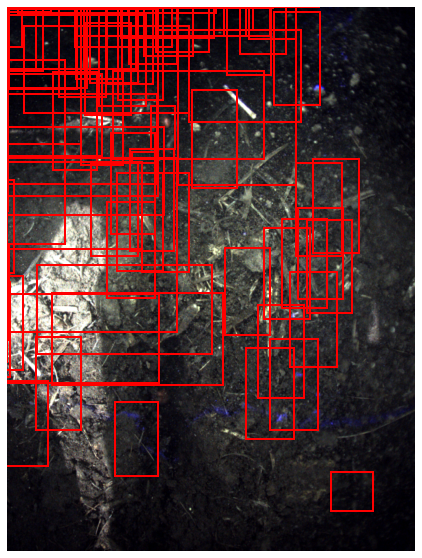

In [ ]:
from posix import sched_param
images = next(iter((test_data_loader)))
images = list(image.to(device) for image in images)


outputs = model(images)

index = 0
img = images[index].permute(1,2,0).cpu().numpy()
boxes = outputs[index]['boxes'].data.cpu().numpy()
scores = outputs[index]['scores'].data.cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

ax.imshow(img)

counter = 0
for box in boxes:
  rect = patches.Rectangle((box[0], box[1]), - (box[2] -  box[0]), -(box[3] - box[1]), linewidth = 2, edgecolor = 'r', facecolor = 'none')
  ax.add_patch(rect)
  print(scores[counter])
  counter += 1
print(img.shape)
ax.set_axis_off()
ax.imshow(img)


[ 633.10205  670.4459  1078.5433   899.8502 ]
102186.15
[   0.      883.7883  629.4432 1329.3829]
280476.47
[ 527.036       1.812721 1007.6712    245.79562 ]
117266.77
[ 251.77353  376.45908 1079.4902   806.538  ]
355983.53
[  5.1040473 125.46843   552.9789    563.0578   ]
239744.19
[ 672.1204  817.8119 1084.0332 1051.9541]
96446.17
[250.52547 502.04227 693.9367  719.404  ]
96380.63
[  5.1323113   0.        272.36957   764.23065  ]
204230.89
[  0.       12.9438  174.62036 496.50623]
84439.85
[ 634.8948  654.1723  891.8848 1202.2384]
140847.53
[  0.         1.826038 109.57019  249.8817  ]
27179.506
[ 362.3993   725.33795 1086.      1206.4896 ]
348161.7
[354.50302 709.182   799.35834 930.0817 ]
98268.414
[  6.4321337   2.5526767 709.32025   308.29694  ]
214904.02
[ 10.12467   63.732365 131.22543  313.07953 ]
30196.133
[ 644.40125  305.80984 1084.637    537.9663 ]
102203.57
[ 725.48627  174.372   1082.8344   410.22565]
84281.85
[ 973.20013  784.2095  1084.9625  1028.2574 ]
27275.385
[265.

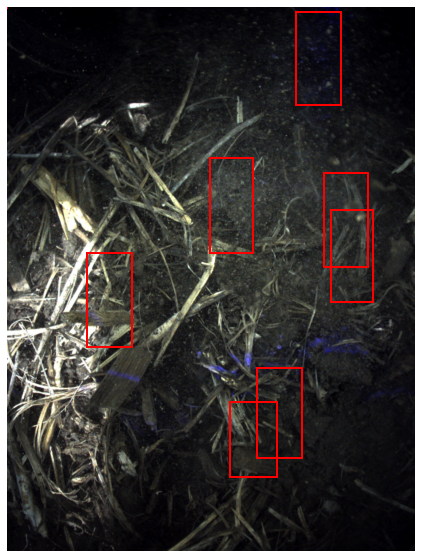

In [ ]:
from posix import sched_param
images = next(iter((test_data_loader)))
images = list(image.to(device) for image in images)


outputs = model(images)

index = 1
img = images[index].permute(1,2,0).cpu().numpy()
boxes = outputs[index]['boxes'].data.cpu().numpy()
scores = outputs[index]['scores'].data.cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

ax.imshow(img)

counter = 0
for box in boxes:
  if counter > 30:
    continue
  print(boxes[counter])
  print((abs(box[0] - box[2]) * abs(box[1] - box[3])) )
  if ((abs(box[0] - box[2]) * abs(box[1] - box[3])) > 30000):
    counter += 1
    continue
  rect = patches.Rectangle((box[0], box[1]), - (box[2] -  box[0]), -(box[3] - box[1]), linewidth = 2, edgecolor = 'r', facecolor = 'none')
  ax.add_patch(rect)
  # print(scores[counter])
  counter += 1

print(img.shape)
ax.set_axis_off()
ax.imshow(img)